# Import the libraries

In [97]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix

import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import statsmodels.api as sm
import seaborn as sns
import pandas as pd
import numpy as np
import warnings

# Prepare the dataframe we will work with

#### Drop the null values

In [98]:
df = pd.read_csv("tracks_2021.csv")

In [99]:
df = df.dropna()

In [100]:
df.head(5)

release_date                           name  duration_ms  danceability  \
0   28/01/2021                     09 01 1966       242068         0.507   
1   04/02/2021                      Year 3000       163680         0.606   
2   10/04/2021                  THE YEAR 3000       114888         0.616   
3   09/04/2021  Logical Brain - Year 3000 Mix       216705         0.745   
4   24/02/2021                      Year 3000       120301         0.712   

   energy  key  loudness  speechiness  acousticness  instrumentalness  \
0   0.341    5   -11.765       0.0302       0.78300          0.000245   
1   0.538   10    -9.353       0.1010       0.09520          0.000384   
2   0.842    4   -14.327       0.1030       0.35700          0.412000   
3   0.732    9   -11.286       0.0759       0.08330          0.928000   
4   0.940    2    -8.064       0.0593       0.00682          0.738000   

   liveness  valence    tempo  explicit  
0    0.1940    0.319  150.142         0  
1    0.1250    0.185  146.918         1  
2    0.6730    0.782  140.063         0  
3    0.0691    0.954  125.004         0  
4    0.1010    0.737  168.066         0

In [101]:
df.dtypes

release_date         object
name                 object
duration_ms           int64
danceability        float64
energy              float64
key                   int64
loudness            float64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
explicit              int64
dtype: object

# Build the Model with StatsModel

#### Check multicolinearity using correlation matrix

In [102]:
X_corr = df.iloc[:, [2, 5, 7, 8, 9, 10, 11]]

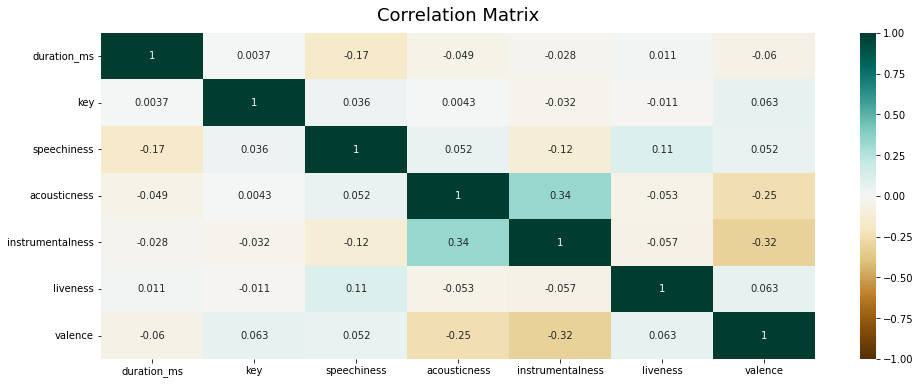

In [103]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(X_corr.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Matrix', fontdict={'fontsize':18}, pad=12);

#### Check multicolinearity using VIF

In [104]:
# Calculating VIF
vif = pd.DataFrame()
vif["variables"] = X_corr.columns
vif["VIF"] = [variance_inflation_factor(X_corr.values, i) for i in range(X_corr.shape[1])]
vif

variables       VIF
0       duration_ms  4.290188
1               key  2.898910
2       speechiness  1.992669
3      acousticness  2.086414
4  instrumentalness  1.363421
5          liveness  2.505681
6           valence  4.165829

#### Fitting a Logistic Regression


In [105]:
log_reg = smf.logit("explicit ~ duration_ms + key + speechiness + acousticness + instrumentalness + liveness + valence", data = df)
result = log_reg.fit()

Optimization terminated successfully.
         Current function value: 0.482811
         Iterations 8


In [106]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               explicit   No. Observations:                 6281
Model:                          Logit   Df Residuals:                     6273
Method:                           MLE   Df Model:                            7
Date:                Tue, 25 Jan 2022   Pseudo R-squ.:                  0.1584
Time:                        18:20:45   Log-Likelihood:                -3032.5
converged:                       True   LL-Null:                       -3603.5
Covariance Type:            nonrobust   LLR p-value:                2.579e-242
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.7718      0.188      4.104      0.000       0.403       1.140
duration_ms      -6.683e-06   7.32e-07     -9.125      0.000   -8.12e-06   -5.25e-06
key                 -0.0322      0.009     -3.680      0.000      -0.049      -0.015
speechiness          5.0623      0.263     19.260      0.000       4.547       5.577
acousticness        -0.5350      0.136     -3.945      0.000      -0.801      -0.269
instrumentalness    -4.2163      0.326    -12.937      0.000      -4.855      -3.578
liveness            -1.0111      0.257     -3.932      0.000      -1.515      -0.507
valence             -1.0775      0.146     -7.404      0.000      -1.363      -0.792
====================================================================================
"""

#### As we can see above, all the independent variables are statistically significant because the p-value is smaller than 0.05

# Define our sklearn model

In [107]:
feature_columns = ['duration_ms', 'key', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence']
X = df[feature_columns]
y = df.explicit

#### Balance the dataset since it's highly umbalanced

In [108]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(sampling_strategy="not minority")
X, y = rus.fit_resample(X, y)

In [109]:
y.value_counts()

0    1637
1    1637
Name: explicit, dtype: int64

#### Scale the independent variables

In [110]:
scaler = StandardScaler()
scaler.fit(X)

StandardScaler()

#### Train-Test Split

In [111]:
X_train, X_test, y_train, y_test_log = train_test_split(X, y, test_size=0.2, random_state=0)

# Logistic Regression Explicit Language

#### Find the Best Hyperparameters to Tune the Model

In [112]:
# # Parameters Grid
# solver = ['newton-cg', 'lbfgs', 'liblinear']
# penalty = ['l1', 'l2']
# C = [100, 10, 1.0, 0.1, 0.01]

# log_regressor = LogisticRegression()

# grid = dict(solver=solver,penalty=penalty,C=C)

# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# grid_search = GridSearchCV(estimator=log_regressor,
#                            param_grid=grid,
#                            n_jobs=-1,
#                            cv=cv,
#                            scoring='accuracy',
#                            error_score=0)

# grid_result = grid_search.fit(X_train, y_train)

# # summarize results
# print(f"Best Model: {round(grid_result.best_score_, 3)} using {grid_result.best_params_}")

#### Creating our regressor object

In [113]:
log_regressor = LogisticRegression(solver = 'newton-cg',
                                   C = 1,
                                   penalty = 'l2',
                                   class_weight="balanced")

#### Fit the model

In [114]:
log_regressor.fit(X_train,y_train)

print(f"Train accuracy: {log_regressor.score(X_train, y_train)}")
print(f"Test accuracy: {log_regressor.score(X_test, y_test_log)}")

Train accuracy: 0.748377243222604
Test accuracy: 0.7603053435114504


#### Check the results with k-fold cross validation

In [115]:
from sklearn.model_selection import cross_val_score
predicted = cross_val_score(log_regressor, X, y, cv=5)
round(predicted.mean(), 3)

0.736

#### Make Predictions

In [116]:
y_pred_log = log_regressor.predict(X_test)

#### f1 Score

In [117]:
print('The f1 score for the model model is:', round(metrics.f1_score(y_test_log, y_pred_log),3))

The f1 score for the model model is: 0.755


#### If f1 score is zero it indicates that the model is performing poorly on the minority class. We can also confirm this by looking at the confusion matrix.

#### Evaluate the model using Confusion Matrix

In [118]:
cnf_matrix = metrics.confusion_matrix(y_test_log, y_pred_log)

In [119]:
cnf_matrix

array([[256,  81],
       [ 76, 242]], dtype=int64)

Text(0.5, 33.0, 'Predicted label')

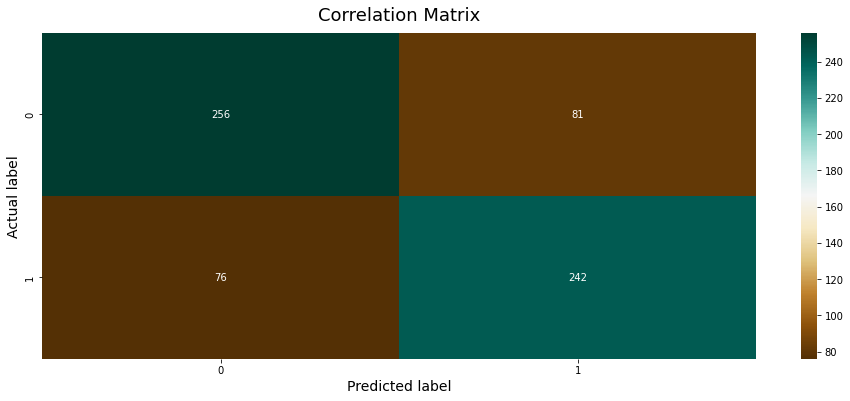

In [120]:
plt.figure(figsize=(16, 6))
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="BrBG" ,fmt='g')
plt.title('Correlation Matrix', fontdict={'fontsize':18}, pad=12)
plt.ylabel('Actual label', size=14)
plt.xlabel('Predicted label', size=14)

In [121]:
print("Accuracy:", round(metrics.accuracy_score(y_test_log, y_pred_log), 4))
print("Precision:", round(metrics.precision_score(y_test_log, y_pred_log), 4))
print("Recall:", round(metrics.recall_score(y_test_log, y_pred_log), 4))

Accuracy: 0.7603
Precision: 0.7492
Recall: 0.761


#### A diagonal line is a random guess that the model defines nonsense. If the curve approaches closer to the top-left corner, the model performance becomes much better. Any curve under the diagonal line is worse than a random guess.

# Decision Tree Explicit Language

In [122]:
y.value_counts()

0    1637
1    1637
Name: explicit, dtype: int64

In [123]:
# X.drop(X.columns[[1, 3]], axis=1, inplace=True)

In [124]:
X_train, X_test, y_train, y_test_dt = train_test_split(X, y, test_size=0.2, random_state=0)

In [125]:
clf_dt = DecisionTreeClassifier(random_state=0)
clf_dt = clf_dt.fit(X_train, y_train)

#### Plot confusion Matrix

In [126]:
y_pred_dt = clf_dt.predict(X_test)

In [127]:
cnf_matrix = metrics.confusion_matrix(y_test_dt, y_pred_dt)

Text(0.5, 33.0, 'Predicted label')

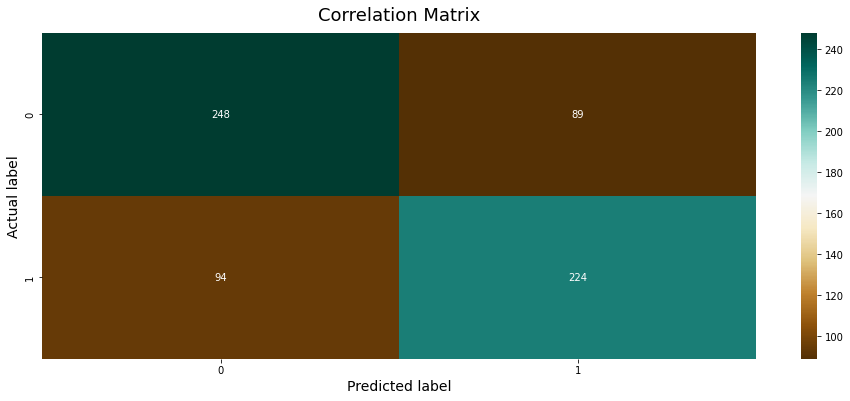

In [128]:
plt.figure(figsize=(16, 6))
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="BrBG" ,fmt='g')
plt.title('Correlation Matrix', fontdict={'fontsize':18}, pad=12)
plt.ylabel('Actual label', size=14)
plt.xlabel('Predicted label', size=14)

#### Maybe we can do better so we will prune the tree

In [129]:
path = clf_dt.cost_complexity_pruning_path(X_train, y_train)    # Determine alpha values
ccp_alphas = path.ccp_alphas   # Extract values for alpha
ccp_alphas = ccp_alphas[:-1]   # Exclude maximum value for alpha

clf_dts = []   # Array to put decision tree into

# Create one decision tree for each alpha and store it in the array
for ccp_alpha in ccp_alphas:
    clf_dt = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf_dt.fit(X_train, y_train)
    clf_dts.append(clf_dt)

#### Graph the accuracy of the trees for both training and testing datasets

In [130]:
train_scores = [clf_dt.score(X_train, y_train) for clf_dt in clf_dts]
test_scores = [clf_dt.score(X_test, y_test_dt) for clf_dt in clf_dts]

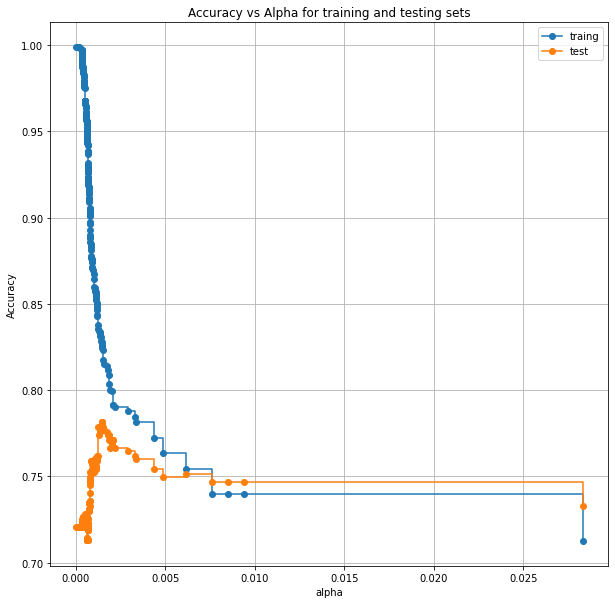

In [131]:
plt.figure(figsize=(10, 10))
plt.xlabel("alpha")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Alpha for training and testing sets")
plt.plot(ccp_alphas, train_scores, marker='o', label="traing", drawstyle="steps-post")
plt.plot(ccp_alphas, test_scores, marker='o', label="test", drawstyle="steps-post")
plt.grid()
plt.legend()
plt.show()

#### Cross Validation to find the best Alpha

In [132]:
clf_dt = DecisionTreeClassifier(random_state=0, ccp_alpha=0.0015)   # Create a tree with 0.001 alpha
cv = 5
scores = cross_val_score(clf_dt, X_train, y_train, cv=cv)
df = pd.DataFrame(data={"tree" : range(cv), "accuracy":scores})

<AxesSubplot:xlabel='tree'>

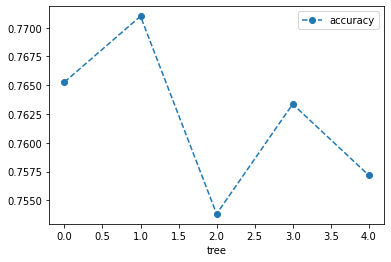

In [133]:
df.plot(x='tree', y='accuracy', marker='o', linestyle='--')

<AxesSubplot:xlabel='alpha'>

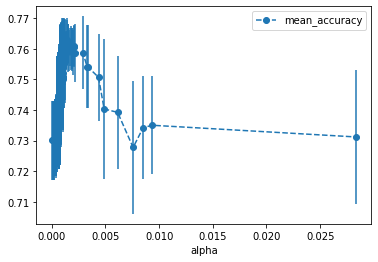

In [134]:
# Create array to store results of each fold during cross validation
alpha_loop_values = []

# For each alpha we will run a 5 fold-cross validation.
# We will store the mean and std of the scores (accuracy) for each call
for ccp_alpha in ccp_alphas:
    clf_dt = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    scores = cross_val_score(clf_dt, X_train, y_train, cv=5)
    alpha_loop_values.append([ccp_alpha, np.mean(scores), np.std(scores)])
    
# Draw a graph of the means and std of the scores
# For each value of alpha
alpha_results = pd.DataFrame(alpha_loop_values, columns=['alpha', 'mean_accuracy', 'std'])
alpha_results.plot(x='alpha', y='mean_accuracy', yerr='std', marker='o', linestyle='--')

In [135]:
alpha_results[(alpha_results['alpha'] > 0.0005) & (alpha_results['alpha'] < 0.003)]

alpha  mean_accuracy       std
53   0.000509       0.742261  0.015258
54   0.000509       0.742261  0.015258
55   0.000509       0.742261  0.015258
56   0.000509       0.742261  0.015258
57   0.000509       0.742261  0.015258
..        ...            ...       ...
209  0.002020       0.758686  0.007418
210  0.002087       0.760977  0.006652
211  0.002098       0.760596  0.006669
212  0.002184       0.758687  0.009449
213  0.002915       0.758690  0.011924

[161 rows x 3 columns]

#### Further, let's store the ideal value for alpha so that we can use it to build the best tree

In [136]:
ideal_ccp_alpha  = alpha_results.loc[alpha_results['mean_accuracy'].idxmax()]
ideal_ccp_alpha

alpha            0.001445
mean_accuracy    0.762884
std              0.007074
Name: 197, dtype: float64

In [137]:
ideal_ccp_alpha = float(ideal_ccp_alpha['alpha'])

In [138]:
ideal_ccp_alpha

0.0014447437127849496

#### Evaluate and draw the final Decision Tree

In [139]:
clf_dt_pruned = DecisionTreeClassifier(random_state=0, ccp_alpha=ideal_ccp_alpha)
clf_dt_pruned = clf_dt_pruned.fit(X_train, y_train)

#### Plot confusion Matrix

In [140]:
y_pred_dt = clf_dt_pruned.predict(X_test)

Feature: 0, Score: 0.07374
Feature: 1, Score: 0.01796
Feature: 2, Score: 0.50953
Feature: 3, Score: 0.03509
Feature: 4, Score: 0.17857
Feature: 5, Score: 0.07120
Feature: 6, Score: 0.11392


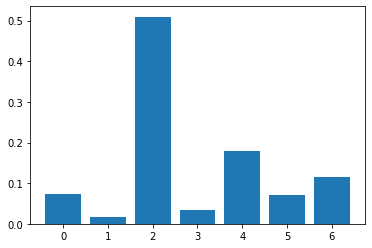

In [141]:
importance = clf_dt_pruned.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [142]:
cnf_matrix = metrics.confusion_matrix(y_test_dt, y_pred_dt)

Text(0.5, 33.0, 'Predicted label')

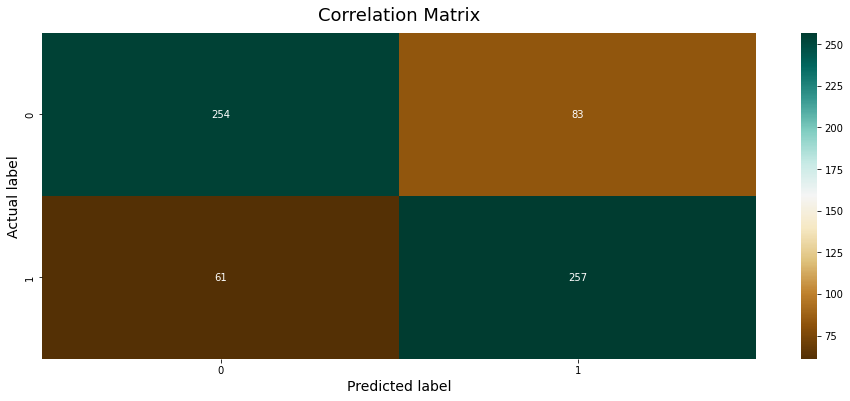

In [143]:
plt.figure(figsize=(16, 6))
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="BrBG" ,fmt='g')
plt.title('Correlation Matrix', fontdict={'fontsize':18}, pad=12)
plt.ylabel('Actual label', size=14)
plt.xlabel('Predicted label', size=14)

# Plot the ROC Curve for the performed Models

In [144]:
fpr_log, tpr_log, thresh_log = metrics.roc_curve(y_test_log, y_pred_log)
fpr_dt, tpr_dt, thresh_dt = metrics.roc_curve(y_test_dt, y_pred_dt)

auc_log = metrics.auc(fpr_log, tpr_log)
auc_dt = metrics.auc(fpr_dt, tpr_dt)

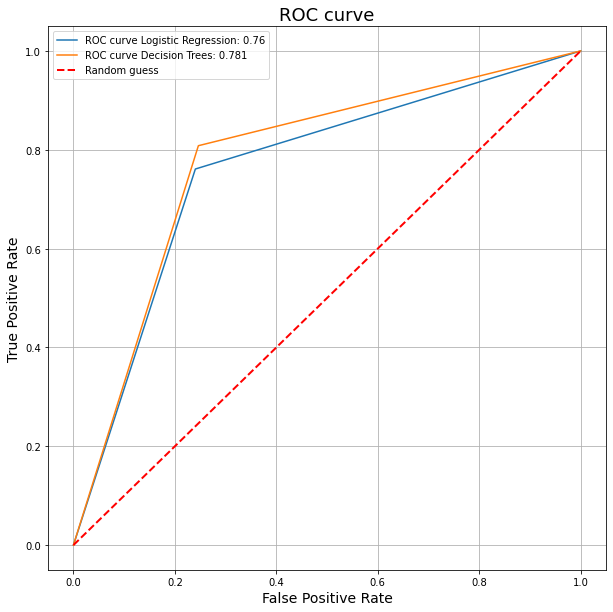

In [145]:
plt.figure(figsize=(10, 10))

plt.plot(fpr_log, tpr_log, label=f'ROC curve Logistic Regression: {round(auc_log, 3)}')
plt.plot(fpr_dt, tpr_dt, label=f'ROC curve Decision Trees: {round(auc_dt, 3)}')

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random guess')
plt.title('ROC curve', size=18)
plt.xlabel('False Positive Rate', size=14)
plt.ylabel('True Positive Rate', size=14)
plt.grid()
plt.legend()
plt.show()